In [1]:
import numpy as np
import pandas as pd
import os,pathlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [2]:
!mkdir /content/images_folder

In [3]:
input_vid='/content/drive/MyDrive/My Response (1).mp4'
final_frames='/content/images_folder/'

In [4]:
#Frame extraction from the video
def extract_frames(input_path,output_path):
    videocapture = cv2.VideoCapture(input_path)
    success,image = videocapture.read()
    count = 0
    while success:
        cv2.imwrite(output_path+"%d.jpg" % count, image)     
        success,image = videocapture.read()
        count += 1
    print('Frames extraction has ended')
    return count

frames = extract_frames(input_vid,final_frames)

Frames extraction has ended


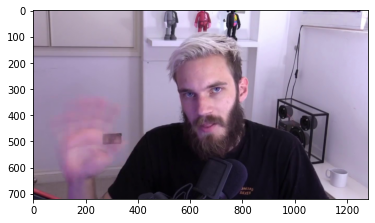

In [5]:
image = cv2.imread('/content/images_folder/1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [6]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 6.7 MB/s 


In [7]:
!mkdir /content/cropped_imgs

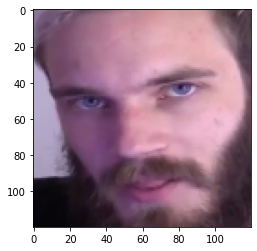

In [8]:
from mtcnn import MTCNN
import cv2
 
detector = MTCNN()
image = cv2.imread('/content/images_folder/1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detections = detector.detect_faces(image)
x, y, width, height = detections[0]['box']
x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
face = image[y1:y2, x1:x2]
face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
plt.imshow(face)
plt.show()

In [9]:
cv2.imwrite(str('/content/')+'tp.jpg',cv2.cvtColor(face,cv2.COLOR_BGR2RGB))

True

In [10]:
def extract_faces(source,destination,detector):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            try:
                image = cv2.imread(str(dirname)+'/'+str(filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                detections = detector.detect_faces(image)
                x, y, width, height = detections[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(str(destination)+filename,cv2.cvtColor(face,cv2.COLOR_BGR2RGB))
                print("Extraction progress: "+str(counter)+"/"+str(len(filenames)-1))
            except:
                pass
            counter += 1

In [11]:
from mtcnn import MTCNN
detector=MTCNN()
extract_faces('/content/images_folder', '/content/cropped_imgs/',detector)

Extraction progress: 0/2863
Extraction progress: 1/2863
Extraction progress: 2/2863
Extraction progress: 3/2863
Extraction progress: 4/2863
Extraction progress: 5/2863
Extraction progress: 6/2863
Extraction progress: 7/2863
Extraction progress: 8/2863
Extraction progress: 9/2863
Extraction progress: 10/2863
Extraction progress: 11/2863
Extraction progress: 12/2863
Extraction progress: 13/2863
Extraction progress: 14/2863
Extraction progress: 15/2863
Extraction progress: 16/2863
Extraction progress: 17/2863
Extraction progress: 18/2863
Extraction progress: 19/2863
Extraction progress: 20/2863
Extraction progress: 21/2863
Extraction progress: 22/2863
Extraction progress: 23/2863
Extraction progress: 24/2863
Extraction progress: 25/2863
Extraction progress: 26/2863
Extraction progress: 27/2863
Extraction progress: 28/2863
Extraction progress: 29/2863
Extraction progress: 30/2863
Extraction progress: 31/2863
Extraction progress: 32/2863
Extraction progress: 33/2863
Extraction progress: 34/

##Encoder

In [12]:
input_img = layers.Input(shape=(120,120, 3))
x = layers.Conv2D(128,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(4608)(x)
encoded = layers.Reshape((3,3,512))(x)
encoder = keras.Model(input_img, encoded,name="encoder")

##Decoder

In [13]:
decoder_input= layers.Input(shape=((3,3,512)))
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((120, 120, 3)))(x)
decoded = layers.Reshape((120, 120, 3))(x)
decoder = keras.Model(decoder_input, decoded,name="decoder")

In [14]:
auto_input = layers.Input(shape=(120,120,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)
 
autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 3, 3, 512)         13548288  
_________________________________________________________________
decoder (Functional)         (None, 120, 120, 3)       32812096  
Total params: 46,360,384
Trainable params: 46,360,384
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##Reading Images in

In [15]:
path_d='/content/cropped_imgs'
ct=0
X = np.zeros((3125,120 , 120, 3), dtype=np.float32)
for path in pathlib.Path(path_d).iterdir():
  img = cv2.imread(str(path))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype('float32')
  X[ct]=img/255
  ct+=1

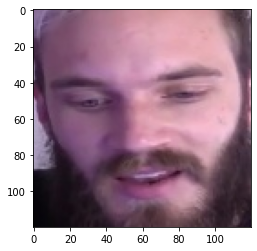

In [16]:
plt.imshow(X[0])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,X, test_size=0.20, random_state=0)

In [18]:
checkpoint1 = ModelCheckpoint("autoencoder_PewDiePie.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history1 = autoencoder.fit(X_train, X_train, epochs=2000, batch_size=128, shuffle=True, validation_data=(X_test, X_test), callbacks=[checkpoint1])

Streaming output truncated to the last 5000 lines.
Epoch 751/2000
20/20 [==============================] - 2s 111ms/step - loss: 0.0244 - val_loss: 0.0244

Epoch 00751: val_loss did not improve from 0.02429
Epoch 752/2000
20/20 [==============================] - 2s 111ms/step - loss: 0.0241 - val_loss: 0.0253

Epoch 00752: val_loss did not improve from 0.02429
Epoch 753/2000
20/20 [==============================] - 2s 112ms/step - loss: 0.0242 - val_loss: 0.0271

Epoch 00753: val_loss did not improve from 0.02429
Epoch 754/2000
20/20 [==============================] - 2s 112ms/step - loss: 0.0243 - val_loss: 0.0243

Epoch 00754: val_loss improved from 0.02429 to 0.02428, saving model to autoencoder_PewDiePie.hdf5
Epoch 755/2000
20/20 [==============================] - 2s 112ms/step - loss: 0.0240 - val_loss: 0.0261

Epoch 00755: val_loss did not improve from 0.02428
Epoch 756/2000
20/20 [==============================] - 2s 112ms/step - loss: 0.0242 - val_loss: 0.0256

Epoch 00756: val

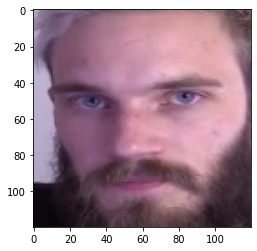

In [19]:
%matplotlib inline
plt.figure()
plt.imshow(X_test[30])
plt.show()

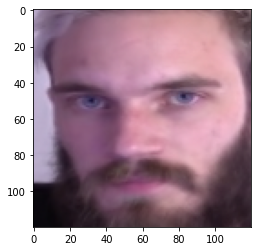

In [20]:
output_image = autoencoder.predict(np.array([X_test[30]]))
plt.figure()
plt.imshow(output_image[0])
plt.show()